In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
from sklearn import linear_model

In [2]:
data = pd.read_csv('operations.csv')
data.head()

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE


In [3]:
########################################################
# NETTOYAGE DU JEU DE DONNÉES
########################################################

data['date_operation'] = pd.to_datetime(data['date_operation'])

# on stocke le df des valeurs manquantes dans un nouveau df
data_na = data.loc[data['montant'].isnull(),:]

# pour chaque ligne de mon df, on récupère les index (qui ne changent pas au travers du .loc)
for index in data_na.index:
    # calcul du montant à partir des soldes précédents et actuels
    data.loc[index, 'montant'] = data.loc[index+1, 'solde_avt_ope'] - data.loc[index, 'solde_avt_ope']
    
data.loc[data['categ'].isnull(), 'categ'] = 'FACTURE TELEPHONE'

data.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], inplace=True, ignore_index=True)
data.loc[data['montant']==-15000, 'montant'] = -14.39

In [4]:
# Analysons la variable montant
data["montant"].describe()

count     308.000000
mean        2.872565
std       176.089858
min      -602.270000
25%       -20.047500
50%        -9.600000
75%        -2.715000
max      1071.600000
Name: montant, dtype: float64

In [5]:
# L'écart-type est énorme devant la moyenne, donc difficile d'interpréter cette moyenne.
# Regardons la médiane
data["montant"].median() # Elle est négative, donc il y a plus de retrait que de rentrées d'argent.

-9.6

In [6]:
data["montant"].mode()

0   -1.6
Name: montant, dtype: float64

In [7]:
for categorie in data["categ"].unique():
    print("\n")
    print(categorie)
    print("Moyenne = %f" % data.loc[data["categ"] == categorie, "montant"].mean())
    print("Ecart-type = %f" % data.loc[data["categ"] == categorie, "montant"].std())
    print("Skewness = %f" % data.loc[data["categ"] == categorie, "montant"].skew())    
    print("Kurtosis = %f" % data.loc[data["categ"] == categorie, "montant"].kurtosis())



AUTRE
Moyenne = 23.433208
Ecart-type = 201.477810
Skewness = 3.121533
Kurtosis = 12.716538


TRANSPORT
Moyenne = -52.997143
Ecart-type = 48.117229
Skewness = -1.248265
Kurtosis = 2.192271


FACTURE TELEPHONE
Moyenne = -12.045714
Ecart-type = 11.068976
Skewness = -2.387651
Kurtosis = 5.798563


COURSES
Moyenne = -16.341282
Ecart-type = 13.479018
Skewness = -1.246749
Kurtosis = 1.604730


COTISATION BANCAIRE
Moyenne = -1.885714
Ecart-type = 0.042762
Skewness = 0.374166
Kurtosis = -2.800000


RESTAURANT
Moyenne = -10.332500
Ecart-type = 1.744536
Skewness = -0.888350
Kurtosis = 0.598886


LOYER
Moyenne = -345.000000
Ecart-type = 0.000000
Skewness = 0.000000
Kurtosis = 0.000000


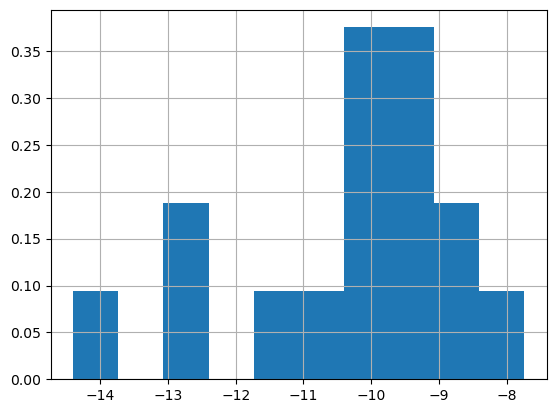

In [8]:
data.loc[data["categ"]=="RESTAURANT", "montant"].hist(density=True, bins=10)
plt.show()

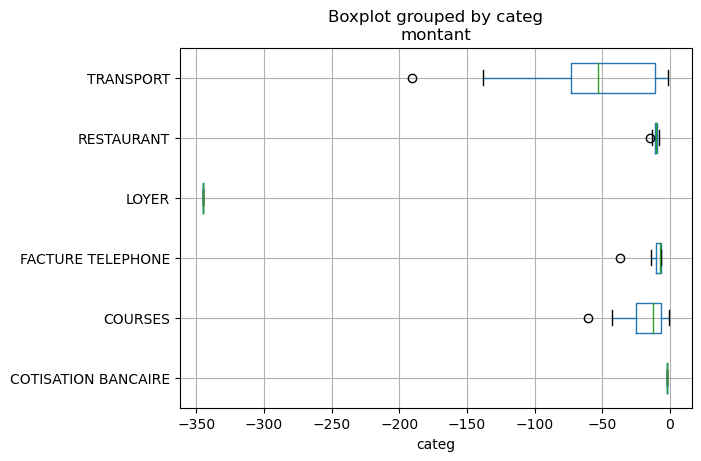

In [9]:
data.loc[data.categ!="AUTRE"].boxplot(column="montant", by = "categ", vert=False)
plt.show()

<AxesSubplot:xlabel='solde_avt_ope', ylabel='montant'>

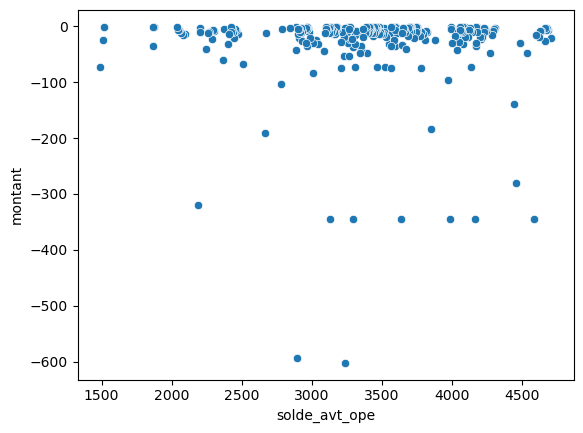

In [10]:
# Est-on moins dépensier quand on a peu d'argent sur son compte ? Voyons ça.
depenses = data.loc[data["montant"]<0, :]
sns.scatterplot(data=depenses, y="montant", x="solde_avt_ope") # On ne voit rien si on considère tous les montants.

In [11]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

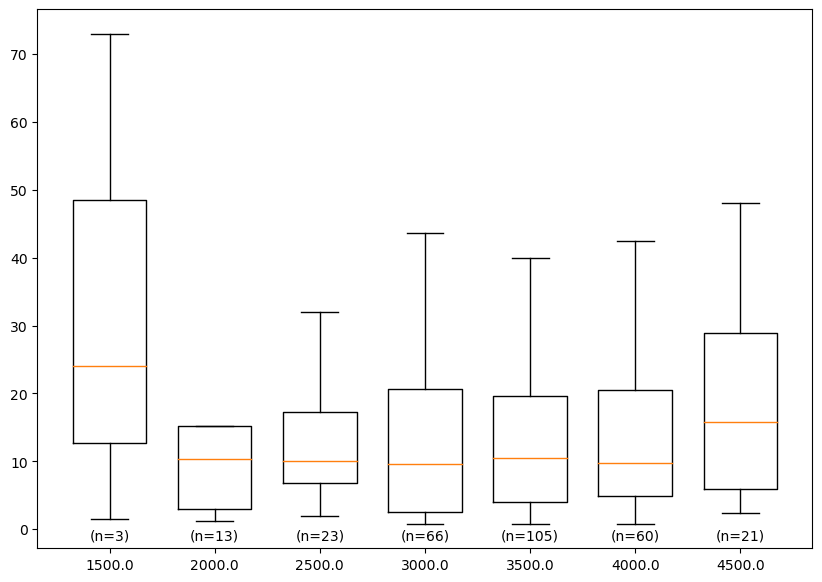

In [12]:
for ind, tr in enumerate(tranches):
    montants = -depenses.loc[indices==ind, "montant"]
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

plt.figure(figsize=(10,7))
        
# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7) # largeur graphique des boxplots

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

In [28]:
st.pearsonr(depenses["solde_avt_ope"], -depenses["montant"])[0]

0.010068819133759177

In [64]:
# On s'intéresse maintenant à l'attente entre deux dépenses relatives aux courses en supermarché.
courses = data[data.categ=="COURSES"].copy(deep=True)
courses.sort_values("date_operation") # On trie les valeurs par date
courses["montant"] = - courses["montant"] # On ramène les dépenses à des valeurs positives

# Calculons l'attente entre deux courses
r = []
last_date = dt.datetime.now()
for i, row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    
    last_date = row["date_operation"]

courses["attente"] = r

# On supprime la première ligne, car l'attente calculée n'a aucun sens.
courses = courses.iloc[1:,]
courses.head()

,date_operation,libelle,montant,solde_avt_ope,categ,attente
19,2023-04-10,CARTE XX XX LES ANCIENS ROBINSON XX,42.42,2885.70,COURSES,5
43,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,32.67,3647.67,COURSES,15
45,2023-04-26,CARTE XX XX LA LOUVE XX XX,1.90,3605.00,COURSES,1
46,2023-04-28,CARTE XX XX LES ANCIENS ROBINSON XX,9.11,3603.10,COURSES,2
49,2023-05-02,CARTE XX XX TOUPTIPRI XX,12.24,3556.59,COURSES,4


In [65]:
# On regroupe les opérations qui ont été réalisées le même jour,  et on supprime par la même occasion les autres colonnes.
courses = courses.groupby("date_operation").agg({"montant" : "sum", "attente" : "first"})
courses.head()

,montant,attente
date_operation,,
2023-04-10,42.42,5
2023-04-25,32.67,15
2023-04-26,1.90,1
2023-04-28,9.11,2
2023-05-02,12.24,4


In [52]:
regressor = linear_model.LinearRegression()
regressor.fit(courses[["attente"]], courses["montant"]) # On prédit la variable "montant" en fonction de potentiellement plusieurs variables, d'où les double-crochets autour de "attente"
print(regressor.coef_, regressor.intercept_)

[1.73657795] 10.94484790874525


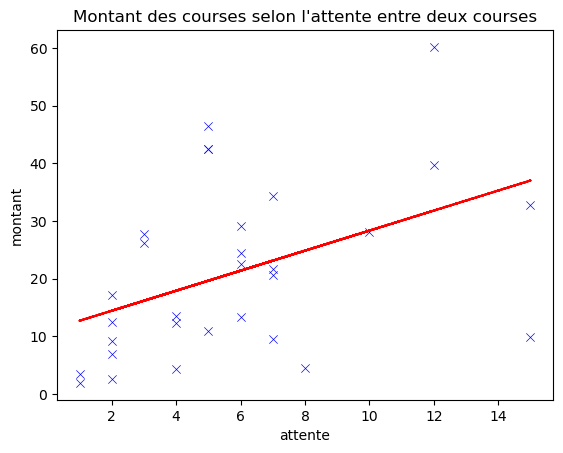

In [66]:
sns.scatterplot(data=courses, x="attente", y="montant", marker="x", color="blue")
plt.plot(courses["attente"], courses["attente"]*regressor.coef_[0]+regressor.intercept_, linestyle = "--", color="red")
plt.title("Montant des courses selon l'attente entre deux courses", fontsize = 12)
plt.show()

In [67]:
# On se rend compte qu'il y a deux courses qui ont eu lieu après 15 jours d'intervalle. Il s'agit d'outliers. Écartons-les.
courses = courses.loc[courses["attente"] < 15]
regressor = linear_model.LinearRegression()
regressor.fit(courses[["attente"]], courses["montant"]) # On prédit la variable "montant" en fonction de potentiellement plusieurs variables, d'où les double-crochets autour de "attente"
print(regressor.coef_, regressor.intercept_)

[3.03082339] 5.4114797136038195


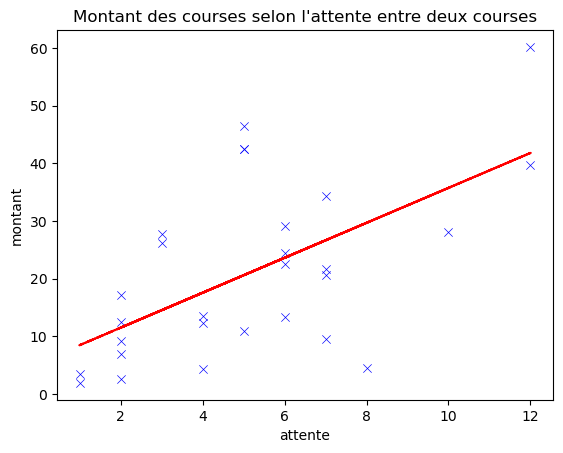

In [68]:
sns.scatterplot(data=courses, x="attente", y="montant", marker="x", color="blue")
plt.plot(courses["attente"], courses["attente"]*regressor.coef_[0]+regressor.intercept_, linestyle = "--", color="red")
plt.title("Montant des courses selon l'attente entre deux courses", fontsize = 12)
plt.show()